# import libraries, activate GPU, fix figure size

In [48]:
# Helper libraries
import datetime
from packaging import version
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

from collections import Counter
import numpy as np
import pandas as pd

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras import models, layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN,RNN, LSTM
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dropout, Flatten, Input, Dense
from tensorflow.keras.datasets import reuters

In [49]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

# load data and learn about data

In [50]:
(data, labels), (_, _) = tf.keras.datasets.reuters.load_data(
                                      path='reuters.npz', num_words=None, skip_top=0, maxlen=None, test_split=0,
                                      seed=113, start_char=1, oov_char=2, index_from=3)

In [51]:
indexes = [word for doc in data for word in doc] 
unique_indexes = list(set(indexes))
len(unique_indexes)

30980

In [52]:
print(f"There are {len(data)} Reuters News Articles with {len(labels)} labels.") 
print(f"There are {len(set(labels))} different label categories.")

There are 11228 Reuters News Articles with 11228 labels.
There are 46 different label categories.


### map class to indices and Report the total number of documents, classes, and frequency distribution

In [53]:
class_to_idx =  \
{'copper': 6, 'livestock': 28, 'gold': 25, 
 'money-fx': 19, 'ipi': 30, 'trade': 11, 
 'cocoa': 0, 'iron-steel': 31, 'reserves': 12, 
 'tin': 26, 'zinc': 37, 'jobs': 34, 'ship': 13, 
 'cotton': 14, 'alum': 23, 'strategic-metal': 27, 
 'lead': 45, 'housing': 7, 'meal-feed': 22, 'gnp': 21, 
 'sugar': 10, 'rubber': 32, 'dlr': 40, 'veg-oil': 2, 
 'interest': 20, 'crude': 16, 'coffee': 9, 'wheat': 5, 
 'carcass': 15, 'lei': 35, 'gas': 41, 'nat-gas': 17, 
 'oilseed': 24, 'orange': 38, 'heat': 33, 'wpi': 43, 
 'silver': 42, 'cpi': 18, 'earn': 3, 'bop': 36, 'money-supply': 8, 
 'hog': 44, 'acq': 4, 'pet-chem': 39, 'grain': 1, 'retail': 29}

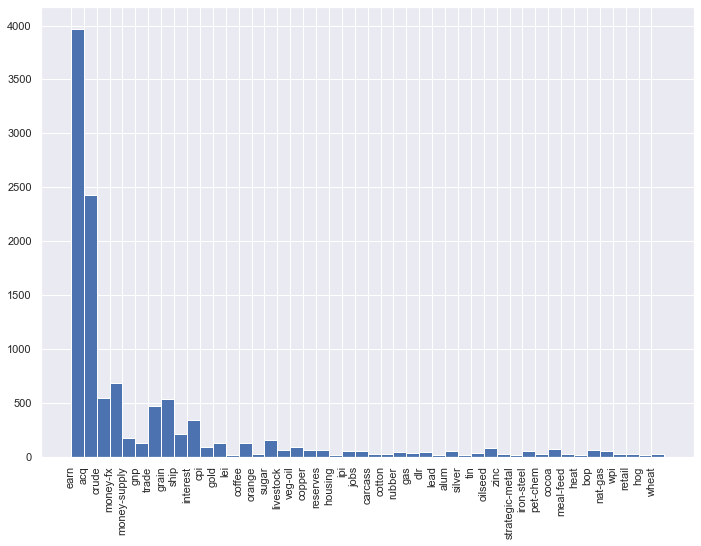

In [54]:
# we reversed the `class_to_idx` dictionary above so that we can decode the labels into classes
idx_to_class = dict([(value, key) for (key, value) in class_to_idx.items()])
classes = [idx_to_class[label] for label in labels]
labs, values = zip(*Counter(classes).items())
indexes = np.arange(len(labs))
width=1
plt.bar(indexes+0.5, values, width)
plt.xticks(indexes, labs, rotation=90)
plt.show()

In [58]:
freqs=[]
infreqs=[]
j=0
for i in values:
    if (i>225):
        freqs.append(j)
    else:
        infreqs.append(j)
    j+=1

In [61]:
freq_dict={}
infreq_dict={}
j=0
for i in freqs:
    freq_dict[i]=j
    j+=1
j=0
for i in infreqs:
    infreq_dict[i]=j
    j+=1

In [63]:
freq_dict

{0: 0, 1: 1, 2: 2, 3: 3, 6: 4, 7: 5, 9: 6}

In [ ]:
infreq_dict

### create a boxplot of data above with, without outliers, and only outliers

In [9]:
freq_list=[]
outliers=[]
for i in freqs:
    freq_list.append(labs[i])
    outliers.append(values[i])
freq_list

['earn', 'acq', 'crude', 'money-fx', 'trade', 'grain', 'interest']

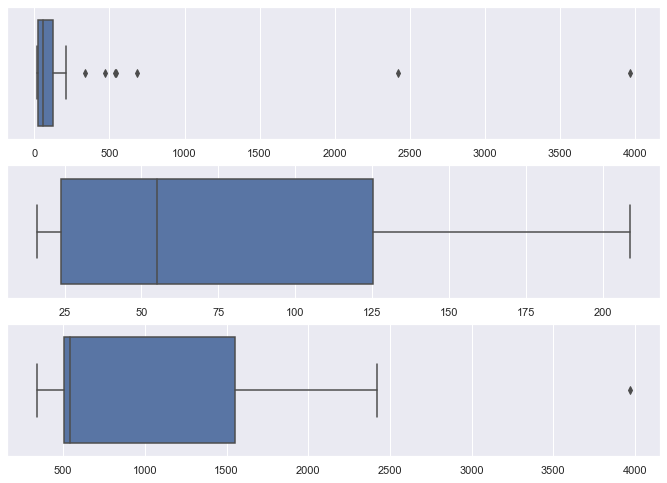

In [10]:
f, (ax1, ax2, ax3) = plt.subplots(3)
sns.boxplot(values, ax=ax1)
sns.boxplot(values, ax=ax2, showfliers=False)
sns.boxplot(outliers, ax=ax3)

# Now that we're done with document classification, lets take a look at words

### Set up the category, word label map like previous, see total number of words/unique words

In [11]:
res = []
for d in data:
    for x in d:
        res.append(x)

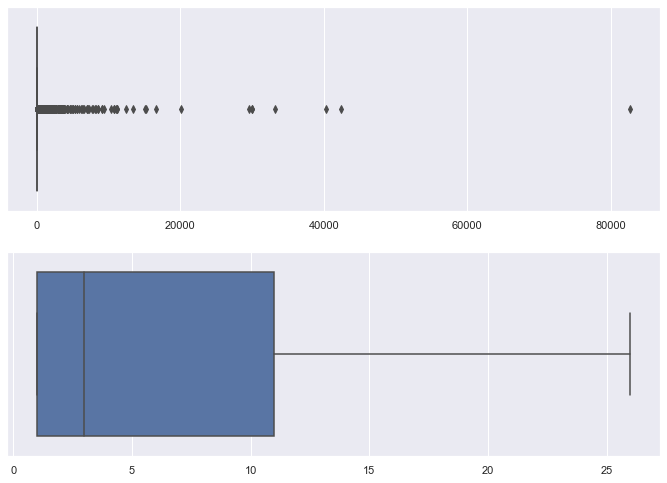

In [44]:
labs, values = zip(*Counter(res).items())
f, (ax1, ax2) = plt.subplots(2)
sns.boxplot(values, ax=ax1)
sns.boxplot(values, ax=ax2, showfliers=False)

Text(0, 0.5, 'Number of Reuters News Articles')

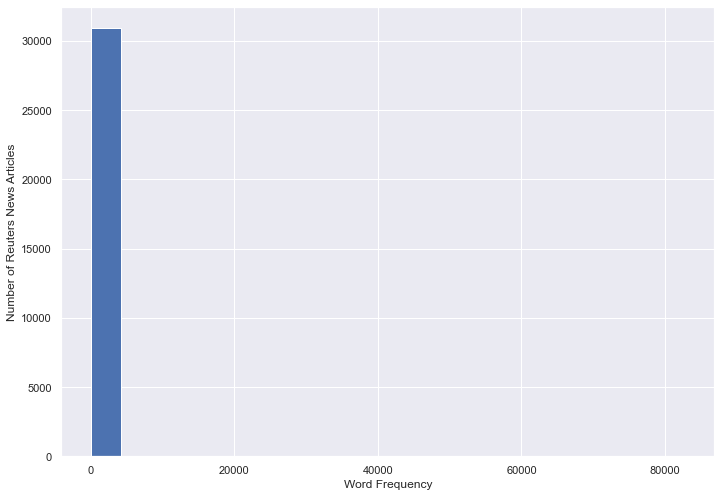

In [13]:
plt.hist(values, bins=20)
plt.xlabel("Word Frequency")
plt.ylabel("Number of Reuters News Articles")

In [14]:
word_index = tf.keras.datasets.reuters.get_word_index()

In [15]:
uniques = [freq for word,freq in word_index.items() if word.isalpha() or len(word)>2]

In [16]:
word_dict = dict(Counter(res))

In [17]:
unique_indexes = list(set(indexes))
print(f"There are {len(unique_indexes)} words in the data corpus that represent the vocabulary")

There are 46 words in the data corpus that represent the vocabulary


### Analyze Data based on the number of words in document

In [18]:
doc_sizes = ([len(lst) for lst in data]) # num of words in each document


Text(0, 0.5, 'Number of Reuters News Articles')

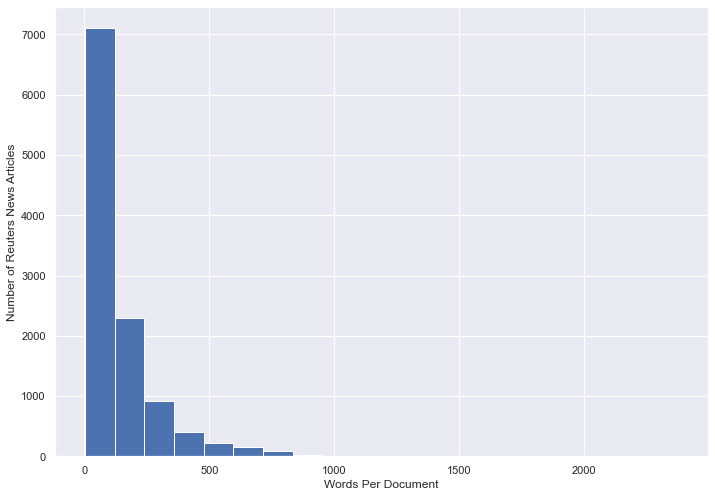

In [19]:
plt.hist(doc_sizes, bins=20)
plt.xlabel("Words Per Document")
plt.ylabel("Number of Reuters News Articles")

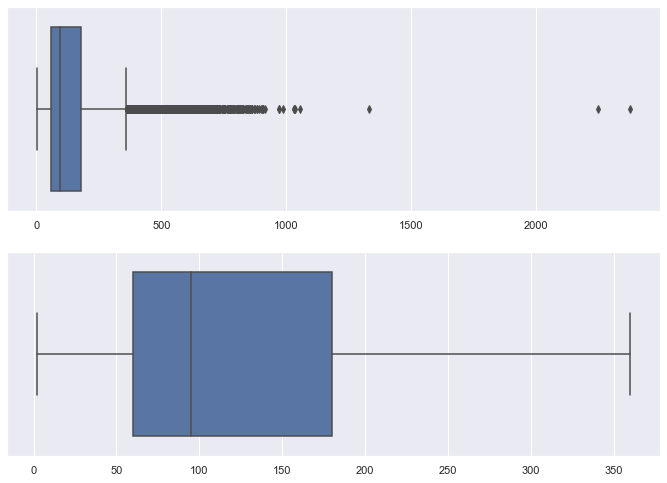

In [20]:
f, (ax1, ax2) = plt.subplots(2)
sns.boxplot(doc_sizes, ax=ax1)
sns.boxplot(doc_sizes, ax=ax2, showfliers=False)

### Preprocess Reuters Dataset

remove words that appear too frequently (whose frequencies are outliers), punctuations, non_alphabetic, too short

In [21]:
processed_text=[]
#for loop to process the text to the processed_text list
for i in data:
    temp=[]
    for k in i:
        if word_dict.get(k)<=30 and k in uniques:
            temp.append(k)
    processed_text.append(temp)


In [22]:
final_processed_text=[]
for i in processed_text:
    lst = [0] * 30980
    for k in i:
        lst[k]+=1
    final_processed_text.append(lst)

In [23]:
doc_sizes = ([len(lst) for lst in processed_text]) # num of words in each document

Text(0, 0.5, 'Number of Reuters News Articles')

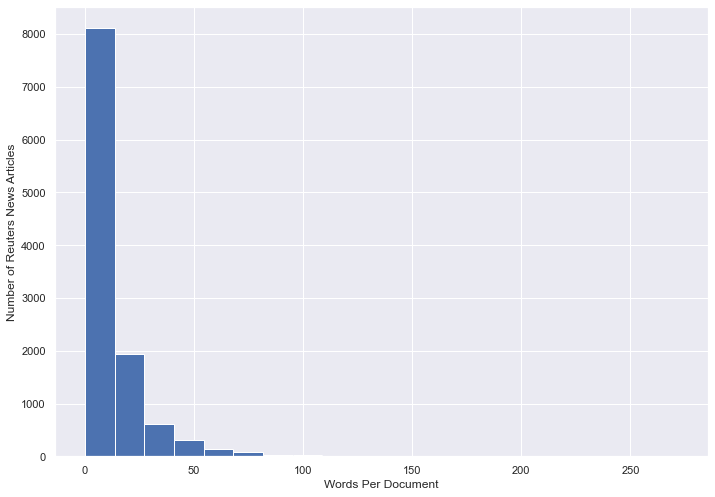

In [24]:
plt.hist(doc_sizes, bins=20)
plt.xlabel("Words Per Document")
plt.ylabel("Number of Reuters News Articles")

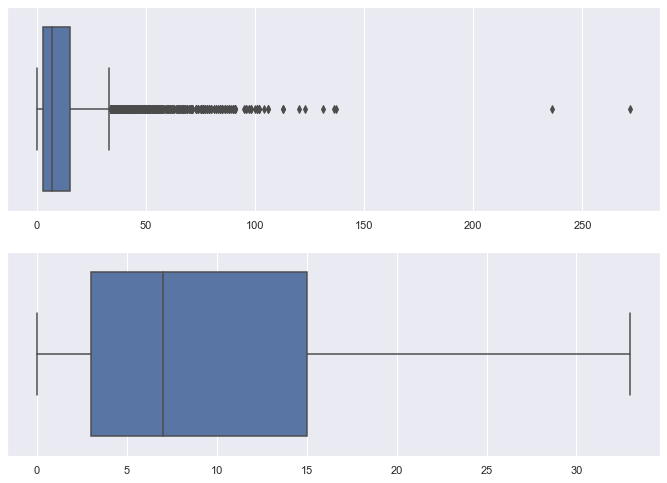

In [25]:
f, (ax1, ax2) = plt.subplots(2)
sns.boxplot(doc_sizes, ax=ax1)
sns.boxplot(doc_sizes, ax=ax2, showfliers=False)

In [24]:
labels_freq=[]
labels_infreq=[]
processed_freq=[]
processed_infreq=[]
final_processed_freq=[]
final_processed_infreq=[]
j = 0
for i in labels:
    if i in freqs:
        labels_freq.append(i)
        processed_freq.append(processed_text[j])
        final_processed_freq.append(final_processed_text[j])
    else:
        labels_infreq.append(i)
        processed_infreq.append(processed_text[j])
        final_processed_infreq.append(final_processed_text[j])
    j+=1

In [25]:
data_rnn_freq = tf.keras.preprocessing.sequence.pad_sequences(final_processed_freq, padding='post')
data_rnn_freq = tf.keras.preprocessing.sequence.pad_sequences(final_processed_freq,maxlen=30980)
labels_freq_encoded = to_categorical(labels_freq)

data_rnn_infreq = tf.keras.preprocessing.sequence.pad_sequences(final_processed_infreq, padding='post')
data_rnn_infreq = tf.keras.preprocessing.sequence.pad_sequences(final_processed_infreq,maxlen=30980)
labels_infreq_encoded = to_categorical(labels_infreq)

data_rnn_freq_v2 = tf.keras.preprocessing.sequence.pad_sequences(processed_freq, padding='post')
data_rnn_freq_v2 = tf.keras.preprocessing.sequence.pad_sequences(processed_freq,maxlen=35)

data_rnn_infreq_v2 = tf.keras.preprocessing.sequence.pad_sequences(processed_infreq, padding='post')
data_rnn_infreq_v2 = tf.keras.preprocessing.sequence.pad_sequences(processed_infreq,maxlen=35)

In [79]:
kfold = KFold(6)
scores = []
for train, test in kfold.split(data_rnn_freq, labels_freq_encoded):
    X_Train=data_rnn_freq[train]
    y_train=labels_freq_encoded[train]
    X_Test=data_rnn_freq[test]
    y_test=labels_freq_encoded[test]
    model = Sequential([
    Dense(name = "hidden_layer", units = 64, activation = tf.nn.relu, input_shape = (30980,)),
    Dense(name = "output_layer", units = 10, activation = tf.nn.softmax)])
    model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    history = model.fit(X_Train,
                    y_train,
                    epochs=10,
                    batch_size=64,
                    validation_split = 0.15)
    loss, accuracy = model.evaluate(X_Test, y_test)
    scores.append(accuracy*100)
    
    pred_classes = np.argmax(model.predict(X_Train), axis=-1)
    print(pred_classes)
    y_train_new=[]
    for i in y_train:
        k=0
        for j in i:
            if j==1:
                y_train_new.append(infreq_dict.get(k))
            k+=1
    y_actual=[]
    for i in pred_classes:
        y_actual.append(infreq_dict.get(i))
    plt.figure(figsize=(16,8))
    conf_mx = tf.math.confusion_matrix(y_train_new, y_actual)
    sns.heatmap(conf_mx, annot=True, cmap='Blues', linewidth=.5)
scores

Epoch 1/10
71/71 [==============================] - 1s 15ms/step - loss: 3.5211 - accuracy: 0.3753 - val_loss: 3.0072 - val_accuracy: 0.3967
Epoch 2/10
71/71 [==============================] - 1s 11ms/step - loss: 2.2109 - accuracy: 0.4787 - val_loss: 2.2547 - val_accuracy: 0.4547
Epoch 3/10
71/71 [==============================] - 1s 11ms/step - loss: 1.4093 - accuracy: 0.6269 - val_loss: 2.0228 - val_accuracy: 0.5113
Epoch 4/10
71/71 [==============================] - 1s 11ms/step - loss: 0.9943 - accuracy: 0.7532 - val_loss: 1.9209 - val_accuracy: 0.5365
Epoch 5/10
71/71 [==============================] - 1s 11ms/step - loss: 0.7381 - accuracy: 0.8297 - val_loss: 1.8869 - val_accuracy: 0.5567
Epoch 6/10
71/71 [==============================] - 1s 10ms/step - loss: 0.5760 - accuracy: 0.8668 - val_loss: 1.8773 - val_accuracy: 0.5567
Epoch 7/10
71/71 [==============================] - 1s 10ms/step - loss: 0.4711 - accuracy: 0.8853 - val_loss: 1.8708 - val_accuracy: 0.5693
Epoch 8/10
71

Epoch 6/10
71/71 [==============================] - 1s 10ms/step - loss: 0.5561 - accuracy: 0.8737 - val_loss: 1.7985 - val_accuracy: 0.5806
Epoch 7/10
71/71 [==============================] - 1s 10ms/step - loss: 0.4460 - accuracy: 0.8949 - val_loss: 1.8036 - val_accuracy: 0.5781
Epoch 8/10
71/71 [==============================] - 1s 11ms/step - loss: 0.3740 - accuracy: 0.9115 - val_loss: 1.8248 - val_accuracy: 0.5781
Epoch 9/10
71/71 [==============================] - 1s 11ms/step - loss: 0.3273 - accuracy: 0.9258 - val_loss: 1.8503 - val_accuracy: 0.5768
Epoch 10/10
34/34 [==============================] - 0s 5ms/step - loss: 1.9247 - accuracy: 0.5586


[62.60623335838318,
 59.112370014190674,
 61.09537482261658,
 60.01890301704407,
 58.41209888458252,
 55.860114097595215]

In [44]:
train_images = train_data_rnn.reshape((8982, 1549, 20,))
test_images = test_data_rnn.reshape((2246, 1549, 20,))

In [51]:
model = models.Sequential()
model.add(layers.Conv1D(filters=32, kernel_size=2, strides=1, activation=tf.nn.sigmoid, input_shape=(1549,20,)))
model.add(layers.MaxPool1D(pool_size=2,strides=None))
model.add(layers.Conv1D(filters=64, kernel_size=2, strides=1, activation=tf.nn.sigmoid))
model.add(layers.MaxPool1D(pool_size=2,strides=None))
model.add(layers.Flatten())
model.add(layers.Dense(units=1024, activation=tf.nn.relu))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(units=46, activation=tf.nn.softmax))

In [52]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [47]:
history = model.fit(train_images,
                    train_labels_encoded,
                    epochs=10,
                    batch_size=64,
                    validation_split = 0.15) 

Epoch 1/10
120/120 [==============================] - 5s 43ms/step - loss: 5.5250 - accuracy: 0.3019 - val_loss: 2.4303 - val_accuracy: 0.3746
Epoch 2/10
120/120 [==============================] - 5s 40ms/step - loss: 2.5034 - accuracy: 0.3414 - val_loss: 2.3994 - val_accuracy: 0.3746
Epoch 3/10
120/120 [==============================] - 5s 40ms/step - loss: 2.4976 - accuracy: 0.3515 - val_loss: 2.4076 - val_accuracy: 0.3746
Epoch 4/10
120/120 [==============================] - 5s 40ms/step - loss: 2.4913 - accuracy: 0.3530 - val_loss: 2.3750 - val_accuracy: 0.3746
Epoch 5/10
120/120 [==============================] - 5s 40ms/step - loss: 2.4862 - accuracy: 0.3530 - val_loss: 2.3797 - val_accuracy: 0.3746
Epoch 6/10
120/120 [==============================] - 5s 40ms/step - loss: 2.4750 - accuracy: 0.3509 - val_loss: 2.3730 - val_accuracy: 0.3746
Epoch 7/10
120/120 [==============================] - 5s 40ms/step - loss: 2.4721 - accuracy: 0.3532 - val_loss: 2.3811 - val_accuracy: 0.3746

In [48]:
loss, accuracy = model.evaluate(test_images, test_labels_encoded)
print('test set accuracy: ', accuracy * 100)

71/71 [==============================] - 1s 9ms/step - loss: 2.4634 - accuracy: 0.3433
test set accuracy:  34.32769477367401


In [49]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)

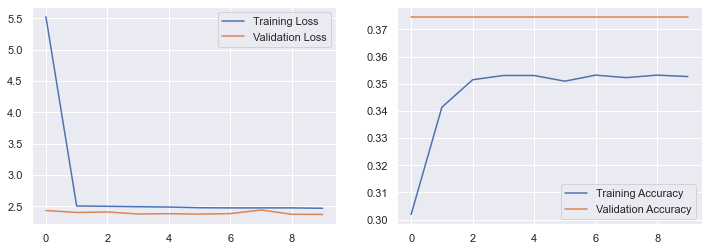

In [50]:
plt.figure(figsize=(12, 4))
for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
plt.show()

In [314]:
res = 0
for i in uniques:
    if i>res:
        res=i
res

30979

In [69]:
class TrainRuntimeCallback(keras.callbacks.Callback):

  def on_train_begin(self,logs={}):
    self.start = datetime.datetime.now()

  def on_train_end(self,logs={}):
    self.process_time = (datetime.datetime.now() - self.start).total_seconds()

In [80]:
kfold = KFold(6)
scores = []
for train, test in kfold.split(data_rnn_freq_v2, labels_freq_encoded):
    X_Train=data_rnn_freq_v2[train]
    y_train=labels_freq_encoded[train]
    X_Test=data_rnn_freq_v2[test]
    y_test=labels_freq_encoded[test]
    model = Sequential()
    model.add(Embedding(input_dim=30980, output_dim=128, input_length=35))
    model.add(SimpleRNN(units=256,activation='relu',use_bias=True))
    model.add(Dense(units=10, activation='softmax'))
    model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    train_rt = TrainRuntimeCallback()
    history = model.fit(X_Train,
                    y_train,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=128,
                    validation_split = 0.15)  
    loss, accuracy = model.evaluate(X_Test, y_test)
    scores.append(accuracy*100)
    pred_classes = np.argmax(model.predict(X_Train), axis=-1)
    print(pred_classes)
    y_train_new=[]
    for i in y_train:
        k=0
        for j in i:
            if j==1:
                y_train_new.append(freq_dict.get(k))
            k+=1
    y_actual=[]
    for i in pred_classes:
        y_actual.append(freq_dict.get(i))
    plt.figure(figsize=(16,8))
    conf_mx = tf.math.confusion_matrix(y_train_new, y_actual)
    sns.heatmap(conf_mx, annot=True, cmap='Blues', linewidth=.5)
scores

Epoch 1/10
36/36 [==============================] - 2s 61ms/step - loss: 5.1887 - accuracy: 0.3662 - val_loss: 3.1879 - val_accuracy: 0.3728
Epoch 2/10
36/36 [==============================] - 2s 54ms/step - loss: 3.0268 - accuracy: 0.3859 - val_loss: 2.6302 - val_accuracy: 0.3715
Epoch 3/10
36/36 [==============================] - 2s 55ms/step - loss: 3.3104 - accuracy: 0.4108 - val_loss: 2.8159 - val_accuracy: 0.3866
Epoch 4/10
36/36 [==============================] - 2s 52ms/step - loss: 2.3239 - accuracy: 0.3928 - val_loss: 2.4485 - val_accuracy: 0.3715
Epoch 5/10
36/36 [==============================] - 2s 52ms/step - loss: 2.2086 - accuracy: 0.4095 - val_loss: 2.7647 - val_accuracy: 0.3980
Epoch 6/10
36/36 [==============================] - 2s 52ms/step - loss: 1.8770 - accuracy: 0.4475 - val_loss: 2.4529 - val_accuracy: 0.3854
Epoch 7/10
36/36 [==============================] - 2s 52ms/step - loss: 1.6941 - accuracy: 0.5187 - val_loss: 2.6650 - val_accuracy: 0.3942
Epoch 8/10
36

Epoch 6/10
36/36 [==============================] - 2s 52ms/step - loss: 1.6957 - accuracy: 0.5183 - val_loss: 2.6858 - val_accuracy: 0.4106
Epoch 7/10
36/36 [==============================] - 2s 51ms/step - loss: 1.4578 - accuracy: 0.5997 - val_loss: 2.1691 - val_accuracy: 0.4610
Epoch 8/10
36/36 [==============================] - 2s 52ms/step - loss: 1.2143 - accuracy: 0.7035 - val_loss: 2.3866 - val_accuracy: 0.4484
Epoch 9/10
36/36 [==============================] - 2s 52ms/step - loss: 0.9798 - accuracy: 0.7548 - val_loss: 2.3897 - val_accuracy: 0.3615
Epoch 10/10
34/34 [==============================] - 0s 5ms/step - loss: 3.9327 - accuracy: 0.2665


[44.75920796394348,
 44.098204374313354,
 28.5174697637558,
 22.58979231119156,
 40.73724150657654,
 26.654064655303955]

In [81]:
kfold = KFold(6)
scores = []
for train, test in kfold.split(data_rnn_freq_v2, labels_freq_encoded):
    X_Train=data_rnn_freq_v2[train]
    y_train=labels_freq_encoded[train]
    X_Test=data_rnn_freq_v2[test]
    y_test=labels_freq_encoded[test]
    LSTMmodel= Sequential()
    LSTMmodel.add(Embedding(input_dim=30980, output_dim=128, input_length=35))
    LSTMmodel.add(LSTM(units = 128))
    LSTMmodel.add(Dropout(0.2))
    LSTMmodel.add(Dense(units = 10, activation='softmax'))
    opt = keras.optimizers.Adam(learning_rate=0.01)
    LSTMmodel.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
    train_rt = TrainRuntimeCallback()
    history = LSTMmodel.fit(X_Train,
                    y_train,
                    callbacks = [train_rt],
                    epochs=10,
                    batch_size=64,
                    validation_split = 0.15) 
    loss, accuracy = model.evaluate(X_Test, y_test)
    scores.append(accuracy*100)
    pred_classes = np.argmax(model.predict(X_Train), axis=-1)
    print(pred_classes)
    y_train_new=[]
    for i in y_train:
        k=0
        for j in i:
            if j==1:
                y_train_new.append(freq_dict.get(k))
            k+=1
    y_actual=[]
    for i in pred_classes:
        y_actual.append(freq_dict.get(i))
    plt.figure(figsize=(16,8))
    conf_mx = tf.math.confusion_matrix(y_train_new, y_actual)
    sns.heatmap(conf_mx, annot=True, cmap='Blues', linewidth=.5)
scores

Epoch 1/10
71/71 [==============================] - 4s 60ms/step - loss: 2.4976 - accuracy: 0.3964 - val_loss: 2.3206 - val_accuracy: 0.4043
Epoch 2/10
71/71 [==============================] - 4s 53ms/step - loss: 1.5294 - accuracy: 0.6127 - val_loss: 2.4124 - val_accuracy: 0.4559
Epoch 3/10
71/71 [==============================] - 4s 53ms/step - loss: 0.8714 - accuracy: 0.7692 - val_loss: 2.5878 - val_accuracy: 0.4395
Epoch 4/10
71/71 [==============================] - 4s 53ms/step - loss: 0.5136 - accuracy: 0.8615 - val_loss: 2.7560 - val_accuracy: 0.4521
Epoch 5/10
71/71 [==============================] - 4s 54ms/step - loss: 0.2992 - accuracy: 0.9177 - val_loss: 2.9682 - val_accuracy: 0.4484
Epoch 6/10
71/71 [==============================] - 4s 54ms/step - loss: 0.2261 - accuracy: 0.9333 - val_loss: 3.0001 - val_accuracy: 0.4660
Epoch 7/10
71/71 [==============================] - 4s 54ms/step - loss: 0.1777 - accuracy: 0.9433 - val_loss: 3.0427 - val_accuracy: 0.4773
Epoch 8/10
71

Epoch 6/10
71/71 [==============================] - 4s 53ms/step - loss: 0.2161 - accuracy: 0.9402 - val_loss: 2.8651 - val_accuracy: 0.4295
Epoch 7/10
71/71 [==============================] - 4s 53ms/step - loss: 0.1844 - accuracy: 0.9480 - val_loss: 2.8252 - val_accuracy: 0.4773
Epoch 8/10
71/71 [==============================] - 4s 53ms/step - loss: 0.1577 - accuracy: 0.9493 - val_loss: 2.8630 - val_accuracy: 0.4924
Epoch 9/10
71/71 [==============================] - 4s 53ms/step - loss: 0.1559 - accuracy: 0.9507 - val_loss: 3.0034 - val_accuracy: 0.4471
Epoch 10/10
34/34 [==============================] - 0s 5ms/step - loss: 3.9327 - accuracy: 0.2665


[76.01510882377625,
 75.1652479171753,
 73.46553206443787,
 75.99244117736816,
 40.92627465724945,
 26.654064655303955]

3


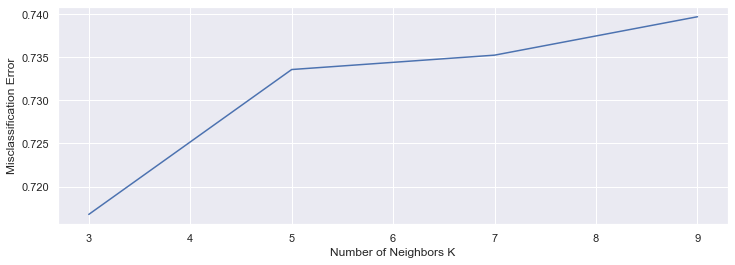

In [366]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
#hyper parameter tuning.Selecting best K
neighbors = [3,5,7,9]
# empty list that will hold cv scores
cv_scores = []
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, train_data_rnn, train_labels_encoded, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())
#graphical view
#misclassification error
MSE = [1-x for x in cv_scores]
#optimal K
optimal_k_index = MSE.index(min(MSE))
optimal_k = neighbors[optimal_k_index]
print(optimal_k)
# plot misclassification error vs k
plt.plot(neighbors, MSE)
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()